# Vision Transformers

In [5]:
# Importing the required packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time
import timeit
from tqdm import tqdm

In [8]:
# Defining the hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

# Setting the seed for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
# Defining the Patch embedding class
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [10]:
# Defing the Vision Transformer class
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


/home/asa/miniconda3/envs/PyTorch-Development/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
submission_df = pd.read_csv("data/sample_submission.csv")

In [16]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [19]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [21]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

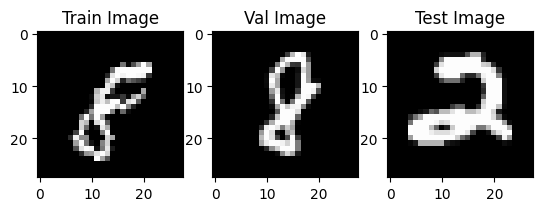

In [22]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [23]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▎         | 1/40 [00:14<09:12, 14.18s/it]

------------------------------
Train Loss EPOCH 1: 2.2567
Valid Loss EPOCH 1: 2.1010
Train Accuracy EPOCH 1: 0.1614
Valid Accuracy EPOCH 1: 0.2426
------------------------------


  5%|▌         | 2/40 [00:28<08:56, 14.11s/it]

------------------------------
Train Loss EPOCH 2: 2.0171
Valid Loss EPOCH 2: 1.8253
Train Accuracy EPOCH 2: 0.2667
Valid Accuracy EPOCH 2: 0.3745
------------------------------


  8%|▊         | 3/40 [00:42<08:43, 14.14s/it]

------------------------------
Train Loss EPOCH 3: 1.7169
Valid Loss EPOCH 3: 1.5325
Train Accuracy EPOCH 3: 0.4109
Valid Accuracy EPOCH 3: 0.4998
------------------------------


 10%|█         | 4/40 [00:56<08:29, 14.15s/it]

------------------------------
Train Loss EPOCH 4: 1.5291
Valid Loss EPOCH 4: 1.4091
Train Accuracy EPOCH 4: 0.4948
Valid Accuracy EPOCH 4: 0.5550
------------------------------


 12%|█▎        | 5/40 [01:10<08:15, 14.16s/it]

------------------------------
Train Loss EPOCH 5: 1.4110
Valid Loss EPOCH 5: 1.2658
Train Accuracy EPOCH 5: 0.5465
Valid Accuracy EPOCH 5: 0.6288
------------------------------


 15%|█▌        | 6/40 [01:25<08:02, 14.20s/it]

------------------------------
Train Loss EPOCH 6: 1.2995
Valid Loss EPOCH 6: 1.1488
Train Accuracy EPOCH 6: 0.6047
Valid Accuracy EPOCH 6: 0.6726
------------------------------


 18%|█▊        | 7/40 [01:39<07:48, 14.20s/it]

------------------------------
Train Loss EPOCH 7: 1.1877
Valid Loss EPOCH 7: 1.0529
Train Accuracy EPOCH 7: 0.6589
Valid Accuracy EPOCH 7: 0.7193
------------------------------


 20%|██        | 8/40 [01:53<07:34, 14.20s/it]

------------------------------
Train Loss EPOCH 8: 1.0782
Valid Loss EPOCH 8: 0.9570
Train Accuracy EPOCH 8: 0.7085
Valid Accuracy EPOCH 8: 0.7571
------------------------------


 22%|██▎       | 9/40 [02:07<07:21, 14.23s/it]

------------------------------
Train Loss EPOCH 9: 0.9859
Valid Loss EPOCH 9: 0.8692
Train Accuracy EPOCH 9: 0.7392
Valid Accuracy EPOCH 9: 0.7886
------------------------------


 25%|██▌       | 10/40 [02:21<07:06, 14.22s/it]

------------------------------
Train Loss EPOCH 10: 0.9144
Valid Loss EPOCH 10: 0.8105
Train Accuracy EPOCH 10: 0.7566
Valid Accuracy EPOCH 10: 0.7962
------------------------------


 28%|██▊       | 11/40 [02:36<06:52, 14.23s/it]

------------------------------
Train Loss EPOCH 11: 0.8479
Valid Loss EPOCH 11: 0.7471
Train Accuracy EPOCH 11: 0.7764
Valid Accuracy EPOCH 11: 0.8160
------------------------------


 30%|███       | 12/40 [02:50<06:38, 14.22s/it]

------------------------------
Train Loss EPOCH 12: 0.8043
Valid Loss EPOCH 12: 0.7140
Train Accuracy EPOCH 12: 0.7865
Valid Accuracy EPOCH 12: 0.8255
------------------------------


 32%|███▎      | 13/40 [03:04<06:22, 14.16s/it]

------------------------------
Train Loss EPOCH 13: 0.7547
Valid Loss EPOCH 13: 0.6882
Train Accuracy EPOCH 13: 0.8003
Valid Accuracy EPOCH 13: 0.8321
------------------------------


 35%|███▌      | 14/40 [03:18<06:09, 14.20s/it]

------------------------------
Train Loss EPOCH 14: 0.7227
Valid Loss EPOCH 14: 0.6277
Train Accuracy EPOCH 14: 0.8083
Valid Accuracy EPOCH 14: 0.8476
------------------------------


 38%|███▊      | 15/40 [03:33<05:56, 14.25s/it]

------------------------------
Train Loss EPOCH 15: 0.6758
Valid Loss EPOCH 15: 0.5824
Train Accuracy EPOCH 15: 0.8236
Valid Accuracy EPOCH 15: 0.8569
------------------------------


 40%|████      | 16/40 [03:47<05:41, 14.21s/it]

------------------------------
Train Loss EPOCH 16: 0.6476
Valid Loss EPOCH 16: 0.5691
Train Accuracy EPOCH 16: 0.8310
Valid Accuracy EPOCH 16: 0.8679
------------------------------


 42%|████▎     | 17/40 [04:01<05:26, 14.21s/it]

------------------------------
Train Loss EPOCH 17: 0.6209
Valid Loss EPOCH 17: 0.5603
Train Accuracy EPOCH 17: 0.8362
Valid Accuracy EPOCH 17: 0.8643
------------------------------


 45%|████▌     | 18/40 [04:15<05:12, 14.22s/it]

------------------------------
Train Loss EPOCH 18: 0.5926
Valid Loss EPOCH 18: 0.5307
Train Accuracy EPOCH 18: 0.8451
Valid Accuracy EPOCH 18: 0.8674
------------------------------


 48%|████▊     | 19/40 [04:29<04:58, 14.24s/it]

------------------------------
Train Loss EPOCH 19: 0.5610
Valid Loss EPOCH 19: 0.4916
Train Accuracy EPOCH 19: 0.8540
Valid Accuracy EPOCH 19: 0.8902
------------------------------


 50%|█████     | 20/40 [04:44<04:44, 14.23s/it]

------------------------------
Train Loss EPOCH 20: 0.5295
Valid Loss EPOCH 20: 0.4491
Train Accuracy EPOCH 20: 0.8639
Valid Accuracy EPOCH 20: 0.8921
------------------------------


 52%|█████▎    | 21/40 [04:58<04:29, 14.19s/it]

------------------------------
Train Loss EPOCH 21: 0.5011
Valid Loss EPOCH 21: 0.4274
Train Accuracy EPOCH 21: 0.8706
Valid Accuracy EPOCH 21: 0.9029
------------------------------


 55%|█████▌    | 22/40 [05:12<04:15, 14.19s/it]

------------------------------
Train Loss EPOCH 22: 0.4896
Valid Loss EPOCH 22: 0.4060
Train Accuracy EPOCH 22: 0.8722
Valid Accuracy EPOCH 22: 0.9040
------------------------------


 57%|█████▊    | 23/40 [05:26<04:01, 14.20s/it]

------------------------------
Train Loss EPOCH 23: 0.4600
Valid Loss EPOCH 23: 0.3977
Train Accuracy EPOCH 23: 0.8810
Valid Accuracy EPOCH 23: 0.9079
------------------------------


 60%|██████    | 24/40 [05:40<03:47, 14.19s/it]

------------------------------
Train Loss EPOCH 24: 0.4466
Valid Loss EPOCH 24: 0.3794
Train Accuracy EPOCH 24: 0.8820
Valid Accuracy EPOCH 24: 0.9079
------------------------------


 62%|██████▎   | 25/40 [05:57<03:45, 15.02s/it]

------------------------------
Train Loss EPOCH 25: 0.4358
Valid Loss EPOCH 25: 0.3768
Train Accuracy EPOCH 25: 0.8837
Valid Accuracy EPOCH 25: 0.9062
------------------------------


 65%|██████▌   | 26/40 [06:17<03:48, 16.31s/it]

------------------------------
Train Loss EPOCH 26: 0.4170
Valid Loss EPOCH 26: 0.3730
Train Accuracy EPOCH 26: 0.8878
Valid Accuracy EPOCH 26: 0.9052
------------------------------


100%|██████████| 9/9 [00:00<00:00, 14.41it/s]


------------------------------
Train Loss EPOCH 27: 0.4045
Valid Loss EPOCH 27: 0.3170


 68%|██████▊   | 27/40 [06:37<03:46, 17.44s/it]

Train Accuracy EPOCH 27: 0.8924
Valid Accuracy EPOCH 27: 0.9231
------------------------------


100%|██████████| 9/9 [00:00<00:00, 13.97it/s]


------------------------------
Train Loss EPOCH 28: 0.3920
Valid Loss EPOCH 28: 0.3205


 70%|███████   | 28/40 [06:57<03:41, 18.43s/it]

Train Accuracy EPOCH 28: 0.8940
Valid Accuracy EPOCH 28: 0.9195
------------------------------


 72%|███████▎  | 29/40 [07:16<03:22, 18.39s/it]

------------------------------
Train Loss EPOCH 29: 0.3746
Valid Loss EPOCH 29: 0.3402
Train Accuracy EPOCH 29: 0.8994
Valid Accuracy EPOCH 29: 0.9107
------------------------------


 75%|███████▌  | 30/40 [07:32<02:57, 17.79s/it]

------------------------------
Train Loss EPOCH 30: 0.3656
Valid Loss EPOCH 30: 0.3005
Train Accuracy EPOCH 30: 0.8991
Valid Accuracy EPOCH 30: 0.9240
------------------------------


 78%|███████▊  | 31/40 [07:47<02:32, 16.98s/it]

------------------------------
Train Loss EPOCH 31: 0.3568
Valid Loss EPOCH 31: 0.2917
Train Accuracy EPOCH 31: 0.9023
Valid Accuracy EPOCH 31: 0.9245
------------------------------


 80%|████████  | 32/40 [08:02<02:10, 16.35s/it]

------------------------------
Train Loss EPOCH 32: 0.3425
Valid Loss EPOCH 32: 0.2817
Train Accuracy EPOCH 32: 0.9062
Valid Accuracy EPOCH 32: 0.9260
------------------------------


 82%|████████▎ | 33/40 [08:17<01:51, 15.99s/it]

------------------------------
Train Loss EPOCH 33: 0.3427
Valid Loss EPOCH 33: 0.2886
Train Accuracy EPOCH 33: 0.9062
Valid Accuracy EPOCH 33: 0.9257
------------------------------


 85%|████████▌ | 34/40 [08:34<01:36, 16.12s/it]

------------------------------
Train Loss EPOCH 34: 0.3231
Valid Loss EPOCH 34: 0.2764
Train Accuracy EPOCH 34: 0.9112
Valid Accuracy EPOCH 34: 0.9314
------------------------------


 88%|████████▊ | 35/40 [08:49<01:19, 15.95s/it]

------------------------------
Train Loss EPOCH 35: 0.3229
Valid Loss EPOCH 35: 0.2574
Train Accuracy EPOCH 35: 0.9093
Valid Accuracy EPOCH 35: 0.9310
------------------------------


 90%|█████████ | 36/40 [09:04<01:02, 15.65s/it]

------------------------------
Train Loss EPOCH 36: 0.3083
Valid Loss EPOCH 36: 0.2747
Train Accuracy EPOCH 36: 0.9137
Valid Accuracy EPOCH 36: 0.9295
------------------------------


 92%|█████████▎| 37/40 [09:19<00:46, 15.45s/it]

------------------------------
Train Loss EPOCH 37: 0.3032
Valid Loss EPOCH 37: 0.2572
Train Accuracy EPOCH 37: 0.9142
Valid Accuracy EPOCH 37: 0.9369
------------------------------


 95%|█████████▌| 38/40 [09:34<00:30, 15.24s/it]

------------------------------
Train Loss EPOCH 38: 0.2961
Valid Loss EPOCH 38: 0.2454
Train Accuracy EPOCH 38: 0.9169
Valid Accuracy EPOCH 38: 0.9362
------------------------------


 98%|█████████▊| 39/40 [09:49<00:15, 15.30s/it]

------------------------------
Train Loss EPOCH 39: 0.2857
Valid Loss EPOCH 39: 0.2656
Train Accuracy EPOCH 39: 0.9194
Valid Accuracy EPOCH 39: 0.9279
------------------------------


100%|██████████| 40/40 [10:05<00:00, 15.15s/it]

------------------------------
Train Loss EPOCH 40: 0.2897
Valid Loss EPOCH 40: 0.2668
Train Accuracy EPOCH 40: 0.9166
Valid Accuracy EPOCH 40: 0.9336
------------------------------
Training Time: 605.90s


In [25]:
torch.save(model.state_dict(), 'model.pth')

In [26]:
torch.cuda.empty_cache()

In [27]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:03<00:00, 16.96it/s]


<Figure size 640x480 with 0 Axes>

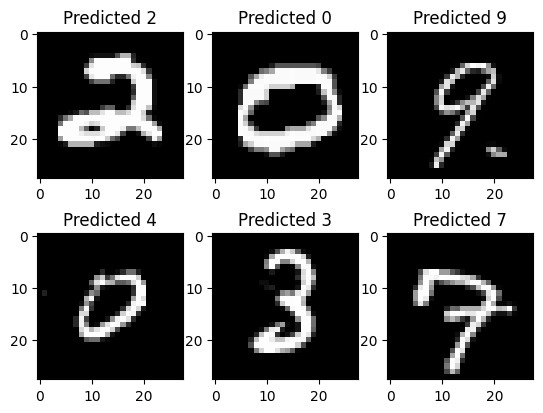

In [28]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [29]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
